In [49]:
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Convolution2D, MaxPooling2D
from sklearn.model_selection import train_test_split
import requests
from io import BytesIO
from zipfile import ZipFile
import json
from tensorflow.keras.utils import array_to_img

-----------------
Read train and test sets

In [50]:
dataset = requests.get("https://www.dropbox.com/s/04r31l2whoyljz7/trafficsigns.zip?dl=1")
with ZipFile(BytesIO(dataset.content)) as z:
  z.extractall(".")
classlabels = requests.get("https://www.dropbox.com/s/lte4x88xdk9x4k2/classlabels.txt?dl=1")
with open("classlabels.txt", 'w') as outfile:
  outfile.write(classlabels.content.decode('utf-8'))

In [51]:
training_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/train', image_size = (128, 128), batch_size = None, seed = 123)]
test_set = [(i, l) for i, l in image_dataset_from_directory('trafficsigns/test', image_size = (128, 128), batch_size = None, seed = 123)]

with open("classlabels.txt") as infile:
  labels = dict((int(i), j) for i, j in json.loads(infile.read()).items())
print("The 20 classes are: " + ", ".join(str(l) for l in labels.values()))

Found 1792 files belonging to 20 classes.
Found 1022 files belonging to 20 classes.
The 20 classes are: limit30, limit50, limit60, limit80, noleft, noright, nouturn, gostraight, goleft, goright, keepright, roundabout, danger, pedestrcross, bikecross, childcross, traincross, construction, nostopping, noentry


-----------
Select labels

In [52]:
labels_to_keep = [0, 6, 4, 18] # Change this to determine which labels to keep (or change to list(range(20)) to keep all labels)
num_classes = len(labels_to_keep)

x_train = np.array([image for image, label in training_set if label in labels_to_keep])
y_train = np.array([labels_to_keep.index(label) for image, label in training_set if label in labels_to_keep])
x_test = np.array([image for image, label in test_set if label in labels_to_keep])
y_test = np.array([labels_to_keep.index(label) for image, label in test_set if label in labels_to_keep])

finallabels = dict([(i, labels[l]) for i, l in enumerate(labels_to_keep)])
print("The " + str(num_classes) + " classes are: " + ", ".join(str(l) for l in finallabels.values()))

The 4 classes are: limit30, nouturn, noleft, nostopping


In [53]:
# RGB images have a depth of 3
x_train.shape

(564, 128, 128, 3)

In [54]:
x_test.shape

(402, 128, 128, 3)

In [55]:
# Normalize pixel values to be between 0 and 1 by dividing by 255. 
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train, x_test = x_train / 255.0, x_test / 255.0

------------
Plot example data

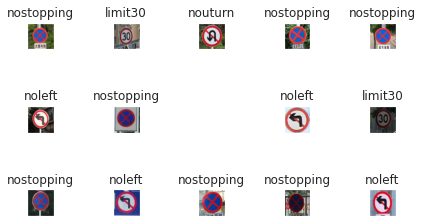

In [56]:
fig = plt.figure()
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.tight_layout()
    img = array_to_img(x_train[i])
    plt.imshow(img)
    plt.title(finallabels[y_train[i]])
    plt.xticks([])
    plt.yticks([])

In [57]:
# check the number of samples
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

564 train samples
402 test samples


In [58]:
def build_fully_connected(input_shape, num_classes):
    """
    Create a fully-connected model to train or test on UC Merced dataset.
    """
    model = Sequential()
    model.add(Flatten(input_shape=(128, 128, 3)))
    model.add(Dense(256))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    return model

In [59]:
# Build, compile, and fit the model
model = build_fully_connected(input_shape=x_train.shape[1:4], num_classes=4)
adam = optimizers.Adam(lr=0.0001)
model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(x_train, y_train, batch_size=32, epochs=10, verbose=1,  validation_data=(x_test, y_test))

Epoch 1/10
18/18 [==============================] - 1s 26ms/step - loss: 2.0292 - accuracy: 0.5833 - val_loss: 1.6002 - val_accuracy: 0.5522
Epoch 2/10
18/18 [==============================] - 0s 11ms/step - loss: 0.6536 - accuracy: 0.8067 - val_loss: 0.6725 - val_accuracy: 0.7313
Epoch 3/10
18/18 [==============================] - 0s 11ms/step - loss: 0.2477 - accuracy: 0.9309 - val_loss: 0.6109 - val_accuracy: 0.7960
Epoch 4/10
18/18 [==============================] - 0s 12ms/step - loss: 0.1641 - accuracy: 0.9574 - val_loss: 0.6393 - val_accuracy: 0.8159
Epoch 5/10
18/18 [==============================] - 0s 12ms/step - loss: 0.1239 - accuracy: 0.9734 - val_loss: 0.6174 - val_accuracy: 0.8259
Epoch 6/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0925 - accuracy: 0.9787 - val_loss: 0.5910 - val_accuracy: 0.8159
Epoch 7/10
18/18 [==============================] - 0s 12ms/step - loss: 0.0698 - accuracy: 0.9858 - val_loss: 0.6119 - val_accuracy: 0.8209
Epoch 8/10
18

13/13 - 0s - loss: 0.5991 - accuracy: 0.8209 - 78ms/epoch - 6ms/step


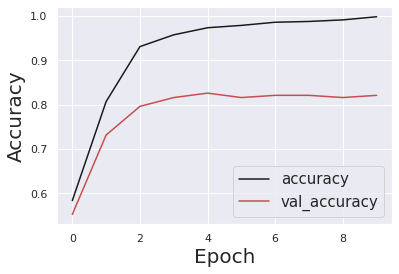

In [60]:
plt.plot(history.history['accuracy'], label='accuracy', color = 'k')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(loc='lower right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
#plt.savefig("visualizations/accuracy_epoch.png",bbox_inches='tight')

13/13 - 0s - loss: 0.5991 - accuracy: 0.8209 - 75ms/epoch - 6ms/step


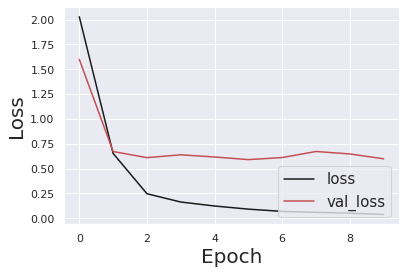

In [61]:
plt.plot(history.history['loss'], label='loss', color = 'k')
plt.plot(history.history['val_loss'], label = 'val_loss', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.legend(loc='lower right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
#plt.savefig("visualizations/loss_epoch.png",bbox_inches='tight')

In [62]:
def create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd):
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(Flatten(input_shape=x_train.shape[1:4]))
    model.add(Dense(64, activation ='relu'))
    model.add(Dense(10))
    model.add(Dropout(0.5))  
    model = build_fully_connected(input_shape=x_train.shape[1:4], num_classes=4)
    adam = optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='sparse_categorical_crossentropy', metrics=['accuracy'])  
    return model

epochs = 10
batch_size = 32
input_shape = x_train.shape[1:4]
receptive_field = 3
n_filters = 10
n_neurons_connected = 20
n_categories = 4

eta_vals = np.logspace(-5, 1, 7)
lmbd_vals = np.logspace(-5, 1, 7)

In [63]:
CNN_keras = np.zeros((len(eta_vals), len(lmbd_vals)), dtype=object)
        
for i, eta in enumerate(eta_vals):
    for j, lmbd in enumerate(lmbd_vals):
        CNN = create_convolutional_neural_network_keras(input_shape, receptive_field,
                                              n_filters, n_neurons_connected, n_categories,
                                              eta, lmbd)
        history = CNN.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, verbose=1, validation_data=(x_test, y_test))
        scores = CNN.evaluate(x_test, y_test)
        
        CNN_keras[i][j] = CNN
        
        print("Learning rate = ", eta)
        print("Lambda = ", lmbd)
        print("Test accuracy: %.3f" % scores[1])
        print()

Epoch 1/10
18/18 [==============================] - 1s 22ms/step - loss: 2.1619 - accuracy: 0.5567 - val_loss: 0.8310 - val_accuracy: 0.7562
Epoch 2/10
18/18 [==============================] - 0s 11ms/step - loss: 0.4930 - accuracy: 0.8316 - val_loss: 0.8534 - val_accuracy: 0.7811
Epoch 3/10
18/18 [==============================] - 0s 12ms/step - loss: 0.2470 - accuracy: 0.9255 - val_loss: 0.7903 - val_accuracy: 0.7811
Epoch 4/10
18/18 [==============================] - 0s 11ms/step - loss: 0.1736 - accuracy: 0.9539 - val_loss: 0.6302 - val_accuracy: 0.8010
Epoch 5/10
18/18 [==============================] - 0s 12ms/step - loss: 0.1237 - accuracy: 0.9770 - val_loss: 0.5962 - val_accuracy: 0.8259
Epoch 6/10
18/18 [==============================] - 0s 11ms/step - loss: 0.1068 - accuracy: 0.9770 - val_loss: 0.5611 - val_accuracy: 0.8209
Epoch 7/10
18/18 [==============================] - 0s 11ms/step - loss: 0.0906 - accuracy: 0.9823 - val_loss: 0.5436 - val_accuracy: 0.7910
Epoch 8/10
18

13/13 [==============================] - 0s 5ms/step - loss: 0.6251 - accuracy: 0.8060


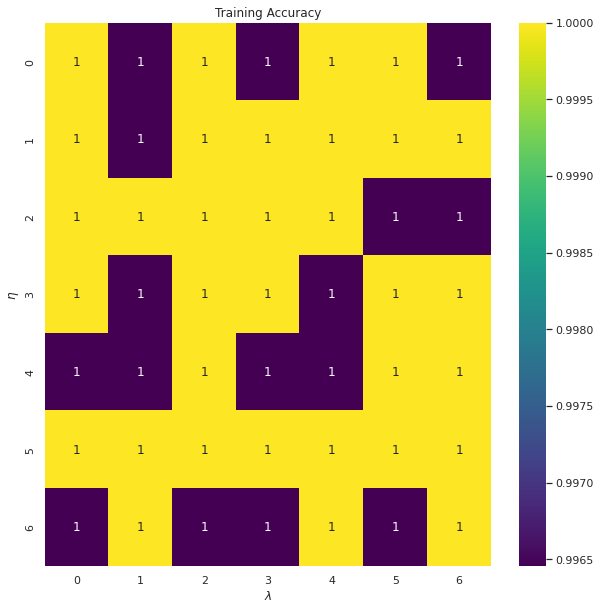

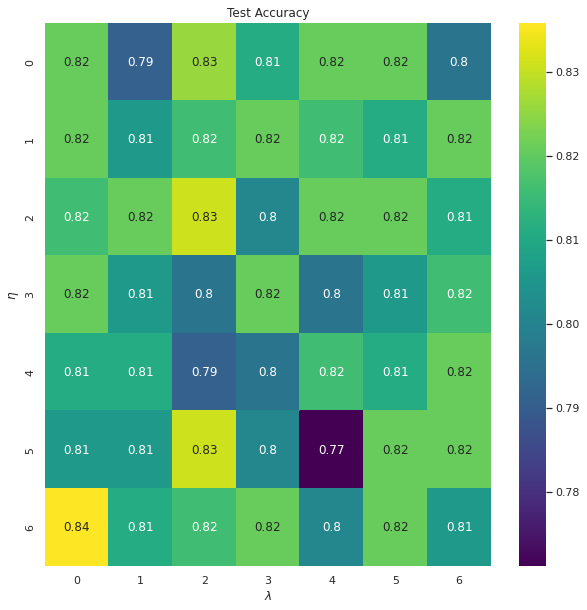

In [64]:
# visual representation of grid search
# uses seaborn heatmap, could probably do this in matplotlib
import seaborn as sns

sns.set()

train_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))
test_accuracy = np.zeros((len(eta_vals), len(lmbd_vals)))

for i in range(len(eta_vals)):
    for j in range(len(lmbd_vals)):
        CNN = CNN_keras[i][j]

        train_accuracy[i][j] = CNN.evaluate(x_train, y_train)[1]
        test_accuracy[i][j] = CNN.evaluate(x_test, y_test)[1]

        
fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(train_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Training Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
#plt.savefig("visualizations/train_accuracy.png",bbox_inches='tight')
#plt.savefig("visualizations/train_accuracy.eps",bbox_inches='tight')
#lt.savefig("visualizations/train_accuracy.pdf",bbox_inches='tight')
plt.show()

fig, ax = plt.subplots(figsize = (10, 10))
sns.heatmap(test_accuracy, annot=True, ax=ax, cmap="viridis")
ax.set_title("Test Accuracy")
ax.set_ylabel("$\eta$")
ax.set_xlabel("$\lambda$")
#plt.savefig("visualizations/test_accuracy.png",bbox_inches='tight')
#plt.savefig("visualizations/test_accuracy.eps",bbox_inches='tight')
#plt.savefig("visualizations/test_accuracy.pdf",bbox_inches='tight')
plt.show()

13/13 - 0s - loss: 0.5991 - accuracy: 0.8209 - 65ms/epoch - 5ms/step


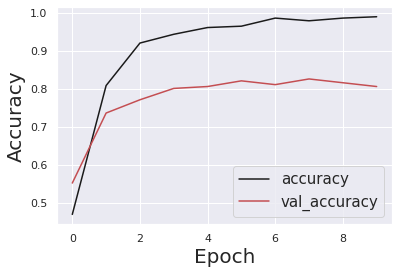

In [65]:
plt.plot(history.history['accuracy'], label='accuracy', color = 'k')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Accuracy', size=20)
plt.legend(loc='lower right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
#plt.savefig("visualizations/accuracy_epoch.png",bbox_inches='tight')

13/13 - 0s - loss: 0.5991 - accuracy: 0.8209 - 67ms/epoch - 5ms/step


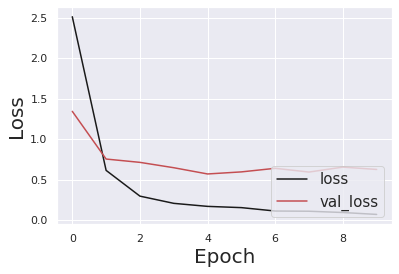

In [66]:
plt.plot(history.history['loss'], label='loss', color = 'k')
plt.plot(history.history['val_loss'], label = 'val_loss', color = 'r')
plt.xlabel('Epoch', size=20)
plt.ylabel('Loss', size=20)
plt.legend(loc='lower right', fontsize=15)
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
#plt.savefig("visualizations/loss_epoch.png",bbox_inches='tight')